## Zillow

For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

You will have a `zillow.ipynb` file and a helper file for each section in the pipeline.

**Summarize Zillow Database**

- airconditioningtype: 13 unique values
    - primary key: airconditioningtypeid


- architecturalstyletype: 27 unique values
    - primary key: architecturalstyletypeid
    
    
- buildingclasstype: 5 unique values
    - primary key: buildingclasstypeid
    
    
- heatingorsystemtype: 25 unique values
    - primary key: heatingorsystemtypeid
    
    
- predictions_2016: all the transactions in 2016 
    - No need to be joined
    
    
- predictions_2017: 77614 records in total
    - primary key: parcelid
    - 77613 records in 2017
    - 1 record in 2018
    - unique id: 77614
    - **unique parcelid: 77414**
    
    
- properties_2016: No need to be joined


- properties_2017: main table
    - primary key: parcelid
    
    
- propertylandusetype
    - primary key: propertylandusetypeid
    
    
- storytype: 35 unique values
    - primary key: storytypeid
    

- typeconstructiontype: 18 unqiue values
    - primary key: typeconstructiontypeid
    
    
- unique_properties: 2,985,217 rows
    - primary key: parcelid

## acquire & summarize

### 1. Acquire data from mySQL using the python module to connect and query. You will want to end with **a single dataframe**. Make sure to include: the logerror, all fields related to the properties that are available. You will end up **using all the tables in the database**.
- Be sure to do **the correct join (inner, outer, etc.)**. We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
- Only include properties with a **transaction in 2017**, and include **only the last transaction for each properity** (so no duplicate property ID's), along with zestimate error and date of transaction.
- Only include properties that include a latitude and longitude value.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import env, acquire, summarize, prepare

In [2]:
# Acquire properties with a transaction in 2017 order first by parcelid then transactiondate

query = """
        select *
        from properties_2017
        join predictions_2017 using(parcelid)
        left join airconditioningtype using(airconditioningtypeid)
        left join architecturalstyletype using(architecturalstyletypeid)
        left join buildingclasstype using(buildingclasstypeid)
        left join heatingorsystemtype using(heatingorsystemtypeid)
        left join propertylandusetype using(propertylandusetypeid)
        left join storytype using(storytypeid)
        left join typeconstructiontype using(typeconstructiontypeid)
        where transactiondate between '2017-01-01' and '2017-12-31'
        order by parcelid, transactiondate
        """

df = acquire.get_zillow_data(query, '1')
df.shape

(77613, 69)

In [3]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,id.1,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,2.0,NaN,NaN,NaN,10711855,1087254,NaN,...,55006,-0.007357,2017-07-07,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,2.0,NaN,NaN,1.0,10711877,1072280,NaN,...,71382,0.021066,2017-08-29,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
2,NaN,NaN,261.0,2.0,NaN,NaN,1.0,10711888,1340933,NaN,...,23209,0.077174,2017-04-04,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,10711910,1878109,NaN,...,18017,-0.041238,2017-03-17,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,NaN,NaN,261.0,2.0,NaN,NaN,NaN,10711923,2190858,NaN,...,20378,-0.009496,2017-03-24,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        223 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77579 non-null  float64
 3   heatingorsystemtypeid         49571 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      207 non-null    float64
 6   airconditioningtypeid         25007 non-null  float64
 7   parcelid                      77613 non-null  int64  
 8   id                            77613 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77579 non-null  float64
 11  bedroomcnt                    77579 non-null  float64
 12  buildingqualitytypeid         49809 non-null  float64
 13  c

In [5]:
# Address duplicates: show all duplicates

mask = df.duplicated(subset='parcelid', keep=False)
df_duplicated = df[mask]
df_duplicated.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,id.1,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
293,NaN,NaN,261.0,2.0,NaN,NaN,NaN,10722858,16179,NaN,...,14033,0.095171,2017-03-02,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
294,NaN,NaN,261.0,2.0,NaN,NaN,NaN,10722858,16179,NaN,...,14034,-0.172843,2017-07-28,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
539,NaN,NaN,261.0,2.0,NaN,NaN,NaN,10732347,1836115,NaN,...,13913,0.077198,2017-03-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
540,NaN,NaN,261.0,2.0,NaN,NaN,NaN,10732347,1836115,NaN,...,13914,-0.221145,2017-07-25,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
721,NaN,NaN,261.0,2.0,NaN,NaN,1.0,10739478,2119208,NaN,...,2904,0.083280,2017-01-13,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [6]:
df_duplicated.shape

(395, 69)

In [ ]:
# Only kee the last transaction (the most recent) for each properity. 

df.drop_duplicates(subset=['parcelid'], keep='last', inplace=True, ignore_index=True)
df.shape

In [ ]:
# Check to see whether the property with most transatction date is kept.

df[(df.parcelid == 10722858) | (df.parcelid == 10732347)]

In [ ]:
# Check if there exsits duplicate property ID

df.duplicated(subset='parcelid').any()

**Takeaways**: Properties with transaction in 2017

### 2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [7]:
zillow = prepare.clean_zillow(df)
zillow.shape

(77414, 69)

In [8]:
# Summary stats

zillow.describe()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id.1,logerror
count,222.000000,50.0,77381.000000,49440.000000,15.000000,206.000000,24953.000000,7.741400e+04,7.741400e+04,50.000000,...,172.0,7.726900e+04,7.738000e+04,77381.0,7.737900e+04,77376.000000,2886.000000,7.713700e+04,77414.000000,77414.000000
mean,6.040541,7.0,261.826340,3.920510,3.933333,7.388350,1.813289,1.300670e+07,1.495774e+06,679.720000,...,1.0,1.893145e+05,4.901345e+05,2016.0,3.010954e+05,5995.532346,14.087318,6.049673e+13,38847.638334,0.016578
std,0.557285,0.0,5.141199,3.592779,0.258199,2.734542,2.967894,3.480690e+06,8.612720e+05,689.703546,...,0.0,2.300874e+05,6.534440e+05,0.0,4.925960e+05,7622.844153,2.185663,1.535242e+12,22403.927709,0.170342
min,4.000000,7.0,31.000000,1.000000,3.000000,2.000000,1.000000,1.071186e+07,3.490000e+02,38.000000,...,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,0.000000,-4.655420
25%,6.000000,7.0,261.000000,2.000000,4.000000,7.000000,1.000000,1.153834e+07,7.524398e+05,273.000000,...,1.0,8.426500e+04,2.070000e+05,2016.0,8.550400e+04,2715.632500,14.000000,6.037311e+13,19458.250000,-0.024387
50%,6.000000,7.0,261.000000,2.000000,4.000000,7.000000,1.000000,1.253072e+07,1.498474e+06,515.000000,...,1.0,1.364990e+05,3.589755e+05,2016.0,2.033720e+05,4450.695000,15.000000,6.037603e+13,38870.500000,0.006624
75%,6.000000,7.0,266.000000,7.000000,4.000000,7.000000,1.000000,1.421149e+07,2.241722e+06,796.500000,...,1.0,2.187870e+05,5.690015e+05,2016.0,3.667965e+05,6927.790000,15.000000,6.059042e+13,58253.750000,0.039211
max,13.000000,7.0,275.000000,24.000000,4.000000,21.000000,13.000000,1.676893e+08,2.985182e+06,3560.000000,...,1.0,1.142179e+07,4.906124e+07,2016.0,4.895220e+07,586639.300000,99.000000,4.830301e+14,77612.000000,5.262999


In [9]:
# Info

zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77414 entries, 0 to 77413
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        222 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77381 non-null  float64
 3   heatingorsystemtypeid         49440 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      206 non-null    float64
 6   airconditioningtypeid         24953 non-null  float64
 7   parcelid                      77414 non-null  int64  
 8   id                            77414 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77381 non-null  float64
 11  bedroomcnt                    77381 non-null  float64
 12  buildingqualitytypeid         49672 non-null  float64
 13  c

In [10]:
# Display object columns and the counts of unique values

zillow_obj_sum = summarize.sum_obj_cols(zillow)
zillow_obj_sum

,dtypes,unique_values
propertycountylandusecode,object,94
propertyzoningdesc,object,1907
taxdelinquencyflag,object,1
transactiondate,object,264
airconditioningdesc,object,5
architecturalstyledesc,object,5
buildingclassdesc,object,2
heatingorsystemdesc,object,10
propertylandusedesc,object,13
storydesc,object,1


In [11]:
# Count unique values in each attributes

summarize.obj_value_counts(zillow)

0100    26714
010C     8813
122      6905
0101     6399
122      6140
        ...  
1432        1
1421        1
1410        1
040G        1
020M        1
Name: propertycountylandusecode, Length: 94, dtype: int64
----------------------------------------------------------------------------------------------------
LAR1        6747
LAR3        2437
LARS        1389
LBR1N       1222
LARD1.5     1127
            ... 
SOR1YY         1
EMM1*          1
SOR1L2         1
AHPPD1O*       1
ESR3VV         1
Name: propertyzoningdesc, Length: 1907, dtype: int64
----------------------------------------------------------------------------------------------------
Y    2886
Name: taxdelinquencyflag, dtype: int64
----------------------------------------------------------------------------------------------------
2017-06-30    1190
2017-04-28     911
2017-05-31     867
2017-07-28     814
2017-08-31     781
              ... 
2017-07-09       1
2017-08-05       1
2017-04-15       1
2017-03-12       1
2017-0

In [12]:
zillow.shape

(77414, 69)

In [13]:
zillow_num = summarize.num_df(zillow)
zillow_num.shape

(77414, 58)

In [14]:
zillow_obj = summarize.obj_df(zillow)
zillow_obj.shape

(77414, 11)

### 3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [15]:
zillow.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,id.1,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,2.0,NaN,NaN,NaN,10711855,1087254,NaN,...,55006,-0.007357,2017-07-07,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,2.0,NaN,NaN,1.0,10711877,1072280,NaN,...,71382,0.021066,2017-08-29,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
2,NaN,NaN,261.0,2.0,NaN,NaN,1.0,10711888,1340933,NaN,...,23209,0.077174,2017-04-04,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,10711910,1878109,NaN,...,18017,-0.041238,2017-03-17,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,NaN,NaN,261.0,2.0,NaN,NaN,NaN,10711923,2190858,NaN,...,20378,-0.009496,2017-03-24,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [16]:
# Compute the number of rows with missing values 

attributes_missing_values = pd.DataFrame(zillow.isna().sum(axis=0), columns=['num_row_missing'])
attributes_missing_values

,num_row_missing
typeconstructiontypeid,77192
storytypeid,77364
propertylandusetypeid,33
heatingorsystemtypeid,27974
buildingclasstypeid,77399
...,...
buildingclassdesc,77399
heatingorsystemdesc,27974
propertylandusedesc,33
storydesc,77364


In [19]:
# Add a column to compute the percent of total rows that have missing values

total_rows = zillow.shape[0]

attributes_missing_values['pct_rows_missing'] = attributes_missing_values.num_row_missing/total_rows
attributes_missing_values

,num_row_missing,pct_rows_missing
typeconstructiontypeid,77192,0.997132
storytypeid,77364,0.999354
propertylandusetypeid,33,0.000426
heatingorsystemtypeid,27974,0.361356
buildingclasstypeid,77399,0.999806
...,...,...
buildingclassdesc,77399,0.999806
heatingorsystemdesc,27974,0.361356
propertylandusedesc,33,0.000426
storydesc,77364,0.999354


In [20]:
# Test the function

attributes_missing_values = summarize.sum_missing_values_attributes(zillow)
attributes_missing_values

,num_row_missing,pct_rows_missing
typeconstructiontypeid,77192,0.997132
storytypeid,77364,0.999354
propertylandusetypeid,33,0.000426
heatingorsystemtypeid,27974,0.361356
buildingclasstypeid,77399,0.999806
...,...,...
buildingclassdesc,77399,0.999806
heatingorsystemdesc,27974,0.361356
propertylandusedesc,33,0.000426
storydesc,77364,0.999354


### 4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [21]:
# Count the rows based on how many missing values in that row. 

x = zillow.isnull().sum(axis=1).value_counts().sort_index()
x

23        2
24       13
25       24
26       65
27      316
28      455
29     5270
30     3455
31     9891
32    12579
33    14782
34    13327
35     5148
36     5775
37     3620
38     1925
39      285
40      230
41       29
42       23
43       28
44       78
45       50
46        5
47        3
48        3
64       33
dtype: int64

In [22]:
# Construct the dictionary from list of lists

cols_missing_values = pd.DataFrame([x.index.tolist(), x.values.tolist()], 
                                   index = ['num_cols_missing', 'num_rows'])
cols_missing_values.T

,num_cols_missing,num_rows
0,23,2
1,24,13
2,25,24
3,26,65
4,27,316
5,28,455
6,29,5270
7,30,3455
8,31,9891
9,32,12579


In [23]:
# Construct the dictionary from dict

d = {'num_cols_missing': x.index.tolist(), 'num_rows': x.values.tolist()}

cols_missing_values = pd.DataFrame(d)
cols_missing_values

,num_cols_missing,num_rows
0,23,2
1,24,13
2,25,24
3,26,65
4,27,316
5,28,455
6,29,5270
7,30,3455
8,31,9891
9,32,12579


In [24]:
# Compute the percent of columns missing

n = zillow.shape[0] # Compuate the total number of rows
cols_missing_values['pct_cols_missing'] = (cols_missing_values.num_rows/n)*100
cols_missing_values

,num_cols_missing,num_rows,pct_cols_missing
0,23,2,0.002584
1,24,13,0.016793
2,25,24,0.031002
3,26,65,0.083964
4,27,316,0.408195
5,28,455,0.587749
6,29,5270,6.807554
7,30,3455,4.463017
8,31,9891,12.776759
9,32,12579,16.248999


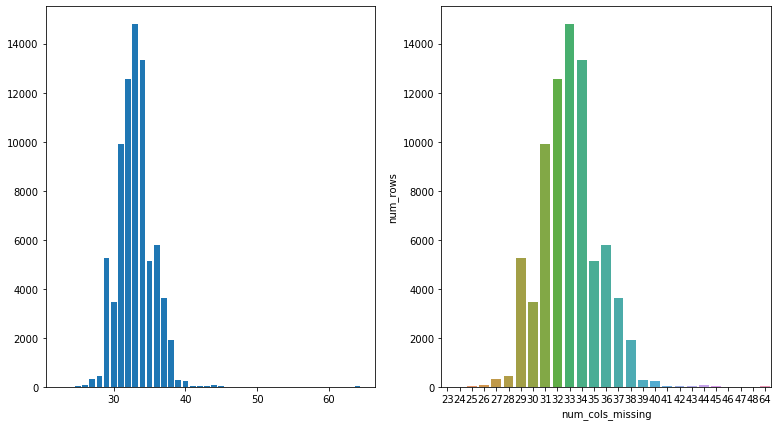

In [25]:
# Visualize the distribution of the 

x = cols_missing_values.num_cols_missing
y = cols_missing_values.num_rows

plt.rc('figure', figsize=(13,7))

plt.subplot(121)
plt. bar(x, y)

plt.subplot(122)
sns.barplot(x, y)

In [26]:
# Test the function

cols_missing_values = summarize.sum_missing_values_cols(zillow)
cols_missing_values

,num_cols_missing,num_rows,pct_cols_missing
0,23,2,0.002584
1,24,13,0.016793
2,25,24,0.031002
3,26,65,0.083964
4,27,316,0.408195
5,28,455,0.587749
6,29,5270,6.807554
7,30,3455,4.463017
8,31,9891,12.776759
9,32,12579,16.248999
